<h1> Advanced Lane Finding Project </h1>

Goal of this project is to find lanes on the road using advanced image processing techniques. Lanes found using this algorithm are more roboust comparing to previous approach.


<h2>Camera calibration </h2>
First step is to perform camera calibration using chessboard images. Camera calibration is done by finding corners and using them to obtain the camera calibration matrix and the distorsion coefficients. Obtained calibration matrix (mtx) and distortion coefficients (dist) are shown below.

In [1]:
# Import needed libraries
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import string

In [2]:
# Function for camera calibration using chessboard images
def get_camera_calibration(images):
    nx = 6
    ny = 9

    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:ny, 0:nx].T.reshape(-1,2)


    for idx, fname in enumerate(images):
        img = cv2.imread(fname)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # Add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Display corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.figure(figsize=(10,10))
            fig = plt.figure()
            plt.imshow(img)
        else:
            print('Warnig: No corners found in %s' %fname)

    plt.close('all') # Comment this to see images


    # Find camera calibration matrix and distorsion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    print('\n\nCalibration matrix, mtx =')
    print(mtx)
    print('\nDistorsion coefficients, dist =')
    print(dist)
    
    return mtx, dist


images = glob.glob('camera_cal/calibration*.jpg')
mtx, dist = get_camera_calibration(images)

Warnig: No corners found in camera_cal/calibration1.jpg
Warnig: No corners found in camera_cal/calibration4.jpg


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Warnig: No corners found in camera_cal/calibration5.jpg


Calibration matrix, mtx =
[[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

Distorsion coefficients, dist =
[[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259868]]


<h2>Distortion correction</h2>
In this section, calibration matrix and distrottion coefficients (mtx) are used to undistort images (dist). For this purpose, a new function "undistort_images" is write. Function takes set of filenames as input, read each of images and undistort them using mtx and dist.

Function is first applied to set of calibration images, and then to set of test images. Undistorted images are shown below and saved to folders: output_images/undistorted/test/ and output_images/undistorted/calib/.

In [4]:
# Function for image undistorting
def undistort_images(images, mtx, dist, img_type):
    for fname in images:
        img = cv2.imread(fname)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        if (img_type == 't'):
            filenameS = fname.replace('test_images/' , '')
            filename = 'output_images/undistorted/test/' + 'undistorted_' + filenameS
        else:
            filenameS = fname.replace('camera_cal/' , '')
            filename = 'output_images/undistorted/calib/' + 'undistorted_' + filenameS
        cv2.imwrite(filename, undist)
        
        f, ax = plt.subplots(1, 2, figsize=(10,8))
        ax[0].imshow(img)
        ax[0].set_title('Input image (distorted)')
        ax[1].imshow(undist)
        ax[1].set_title('Undistorted image')
    plt.show()

In [5]:
# save calibration
cal_pickle = {}
cal_pickle['mtx'] = mtx
cal_pickle['dist'] = dist
with open('camera_cal/cal_pickle_new.p','wb') as output_file:
    pickle.dump(cal_pickle, output_file)

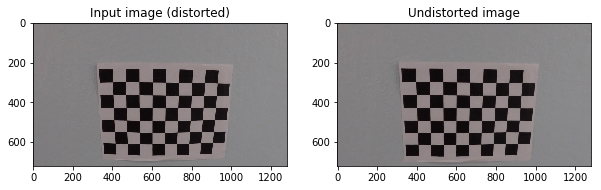

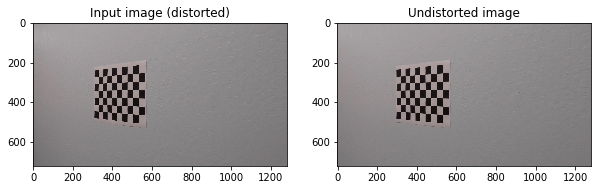

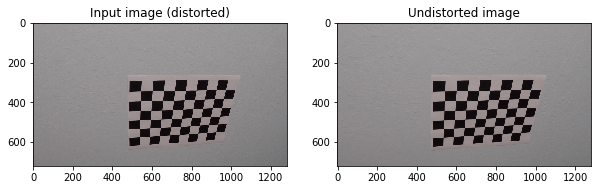

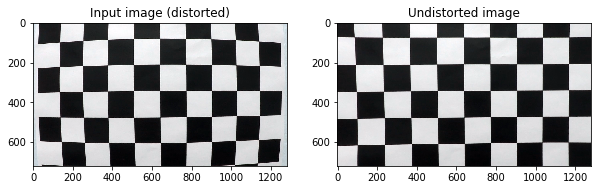

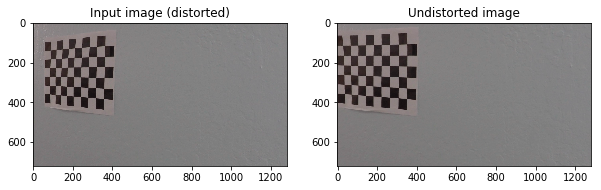

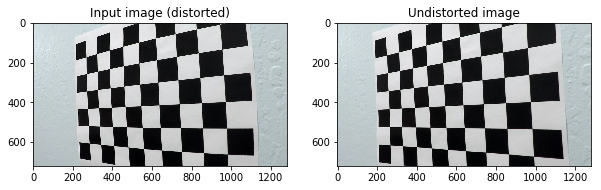

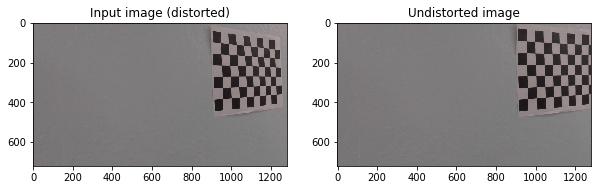

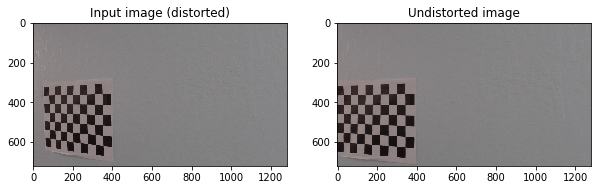

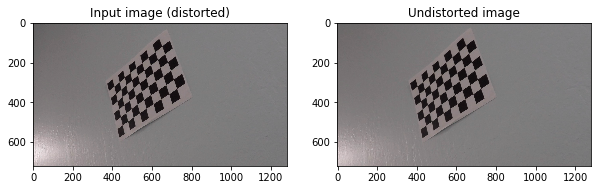

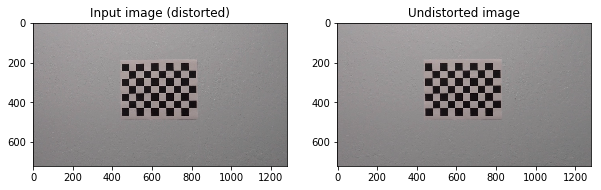

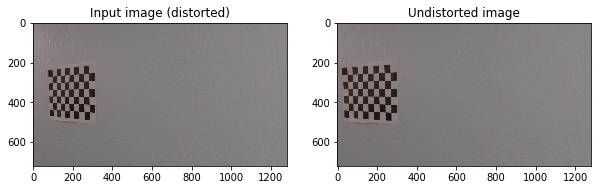

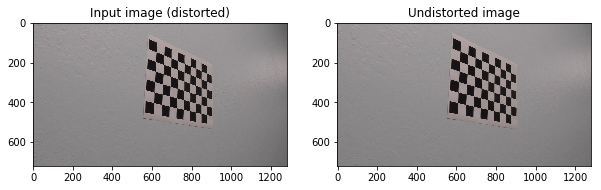

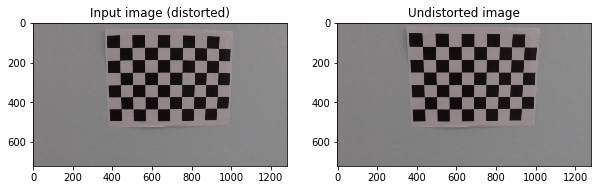

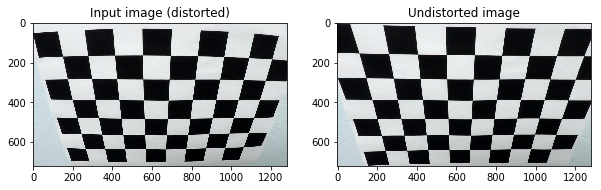

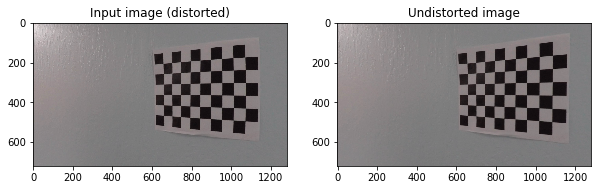

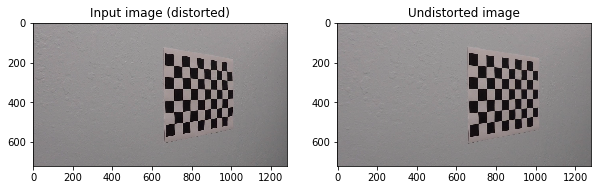

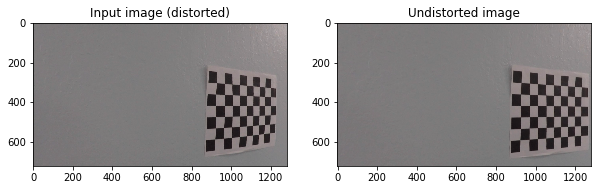

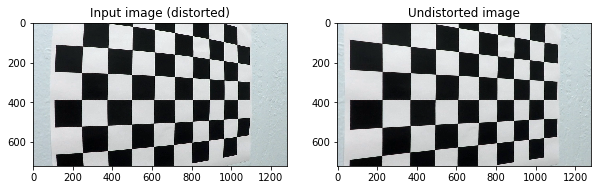

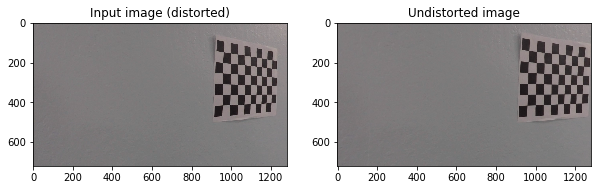

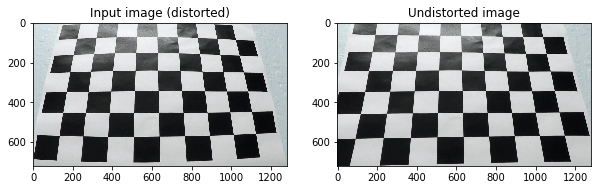

In [6]:
# Undistort calibration images
images_calib = glob.glob('camera_cal/calibration*.jpg')
undistort_images(images_calib, mtx, dist, 'c')

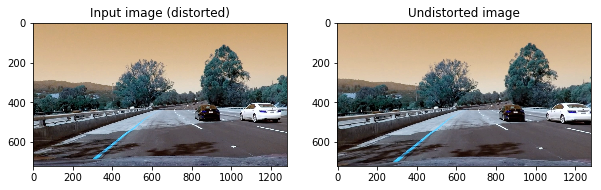

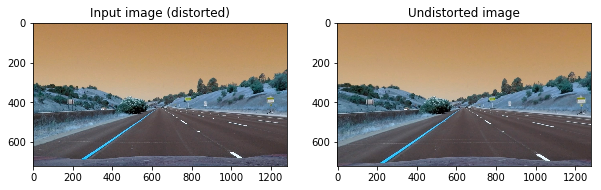

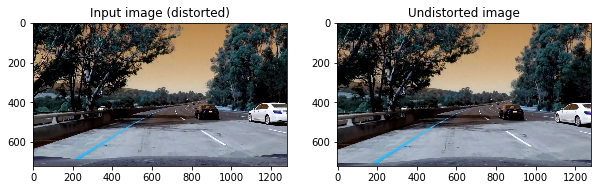

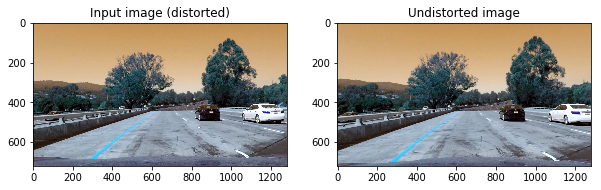

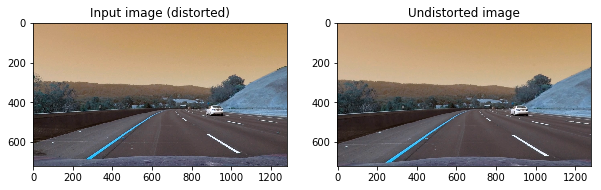

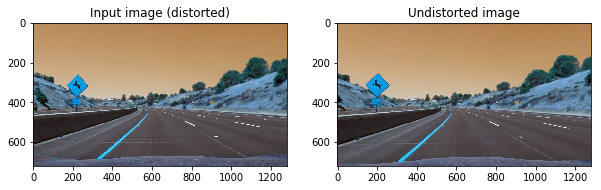

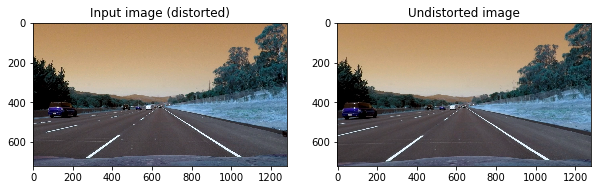

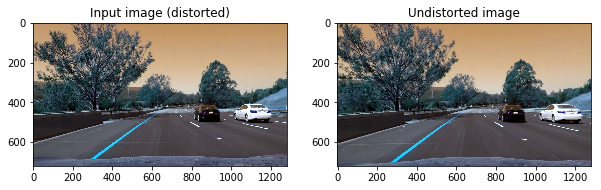

In [7]:
# Undistort test images
images_test = glob.glob('test_images/*.jpg')
undistort_images(images_test, mtx, dist, 't')

<h2>Thresholding</h2>

The next section performs image thresholding. Image is thresholded using several techniques. 

First sobel threshold is used by calculating gradient in x direction (absolute of derivative in x direction). Caclulated gradient is then thresholded with lower threshold = 40 and upper threshold = 200.

After sobel thresholding, color thresholding is applied on image in RGB space. Color thresholding is defined to select white and yellow colors.

Additionaly, image is transformed in HLS and HSV color spaces, and S and V channels are selected and tresholded.

Final trhesholded image is produced as combination of all thresholded images.

In [2]:
# Function for sobel thresholding
def thresholding_sobel(img, sx_thresh=(30, 200)):

    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 255
    return sxbinary

def sobel_threshold_xy(img, kernel_size=3, thres=(np.pi/4, np.pi/2)):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    sxy = np.arctan2(sx_abs, sy_abs)

    sxybinary = np.zeros_like(sxy)
    sxybinary[(sxy >= thres[0]) & (sxy <= thres[1])] = 255
    
    return sxybinary

# Function to get binary image from defined range
def get_color_image(img, lower_range, upper_range):
    rgb_color = cv2.inRange(img, lower_range, upper_range)
    return rgb_color

# Function to combine white and yellow binary image
def thresholding_color(img):
    white = get_color_image(img, (200, 200, 200), (255, 255, 255))
    yellow = get_color_image(img, (0, 100, 100), (80, 255, 255))
    
    color_binary = cv2.bitwise_or(yellow, white)
    return color_binary

In [3]:
# HSV color space
def hsv_thresholding(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    thresh = (227, 255)
    hsv_binary = np.zeros_like(hsv_img[:,:,2])
    hsv_binary[(hsv_img[:,:,2] >= thresh[0]) & (hsv_img[:,:,2] <= thresh[1])] = 255
    return hsv_binary

# HLS color space
def hls_thresholding(img):
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # get s chanel
    thresh = (200, 255)
    hls_binary = np.zeros_like(hls_img[:,:,2])
    hls_binary[(hls_img[:,:,2] >= thresh[0]) & (hls_img[:,:,2] <= thresh[1])] = 255
    return hls_binary


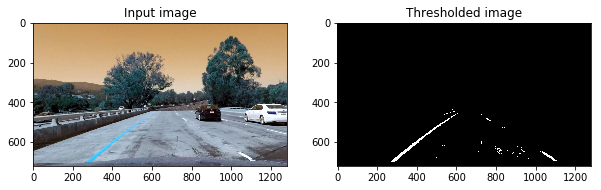

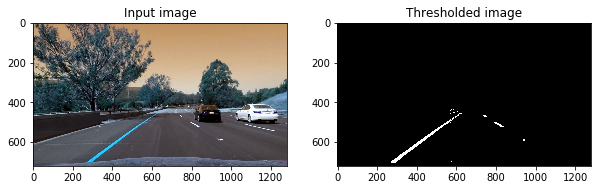

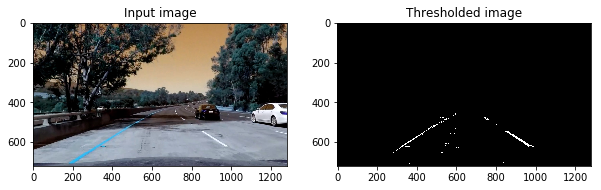

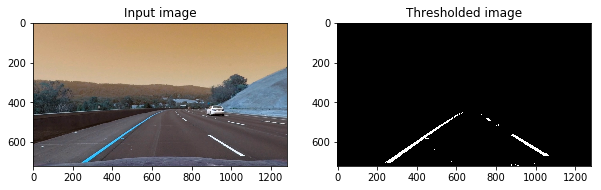

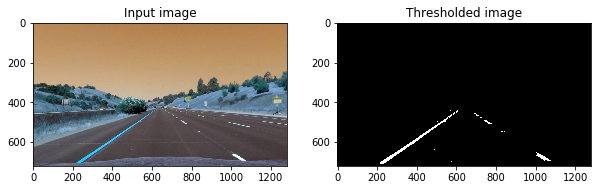

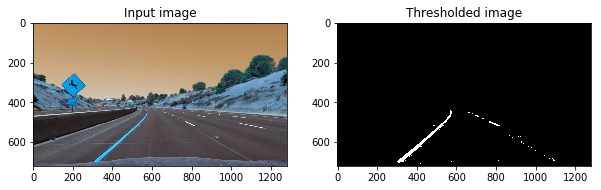

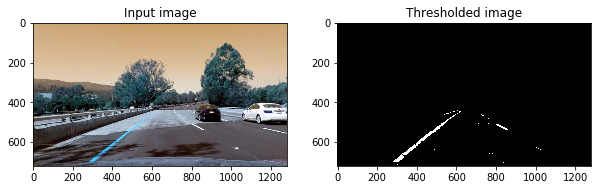

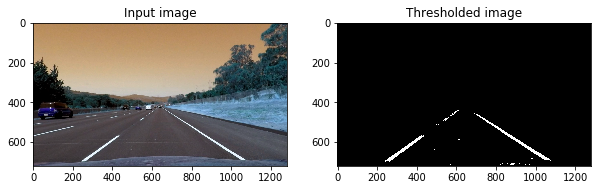

In [11]:
# Function to combine all binary images
def appling_blur(img, kernel_size):
    img_blur = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return img_blur

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def thresholding_image(img, fname):
    
    filenameS = fname.replace('output_images/undistorted/test/' , '')

    sobel_threshold = thresholding_sobel(img)
    filename = 'output_images/thresholding/' + 'sobel_' + filenameS
    cv2.imwrite(filename, sobel_threshold)
    
    #filename = 'output_images/thresholding/' + 'sobel_xy_' + filenameS
    #sobel_xy_threshold = sobel_threshold_xy(img)
    #cv2.imwrite(filename, sobel_xy_threshold)
    
    color_threshold = thresholding_color(img)
    filename = 'output_images/thresholding/' + 'color_' + filenameS
    cv2.imwrite(filename, color_threshold)
    
    threshold_img1 = cv2.bitwise_or(sobel_threshold, color_threshold)
    
    threshold_hsv = hsv_thresholding(img)
    filename = 'output_images/thresholding/' + 'hsv_' + filenameS
    cv2.imwrite(filename, threshold_hsv)
    
    threshold_hls = hls_thresholding(img)
    filename = 'output_images/thresholding/' + 'hls_' + filenameS
    cv2.imwrite(filename, threshold_hls)
    
    threshold_img2 = cv2.bitwise_or(threshold_hsv, threshold_hls)
    
    threshold_img = cv2.bitwise_or(threshold_img1, threshold_img2)
    
    imshape = threshold_img.shape
    vertices = np.array([[
        (0.15 * imshape[1] ,imshape[0]), 
        (0.45 * imshape[1], 0.6 * imshape[0]), 
        (0.6 * imshape[1], 0.65 * imshape[0]),
        (0.9 * imshape[1], imshape[0]) 
    ]], dtype=np.int32)
    masked_threshold = region_of_interest(threshold_img, vertices)
    
    return masked_threshold

def thresholding_all(images):
    for fname in images:
        img = cv2.imread(fname)
        
        img_blur = appling_blur(img, 5)
        
        threshold_img = thresholding_image(img_blur, fname)
              
        f, ax = plt.subplots(1, 2, figsize=(10,8))
        ax[0].imshow(img)
        ax[0].set_title('Input image')
        ax[1].imshow(threshold_img, cmap='gray')
        ax[1].set_title('Thresholded image')
        plt.show()

        filenameS = fname.replace('output_images/undistorted/test/undistorted_' , '')
        filename = 'output_images/' + 'threshold_' + filenameS
        
        cv2.imwrite(filename, threshold_img)

with open('camera_cal/cal_pickle.p', 'rb') as calib_file:
    p = pickle.load(calib_file)
mtx = p['mtx']
dist = p['dist']

images = glob.glob('output_images/undistorted/test/*.jpg')
thresholding_all(images)

<h2>Perspective transformation</h2>

In this section perspective transformation is performed. 




In [12]:
def warpPerspective(img, M):
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped

def getPerspectiveTransform(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    return M

def warping(img):
   
    src = np.float32([[220, 720],[1110, 720],[570, 470],[722, 470]])
    dst = np.float32([[320,720], [920,720], [320,1], [920,1]])

    #print(src)
    #print(dst)
    M = getPerspectiveTransform(src, dst)    
    birdseye = warpPerspective(img, M)
    
    Minv = getPerspectiveTransform(dst, src) 
    
    return birdseye, M, Minv

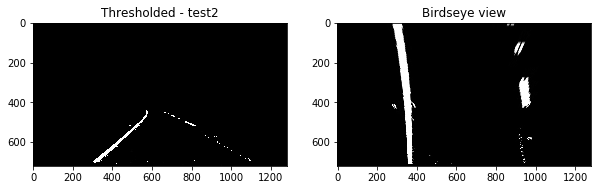

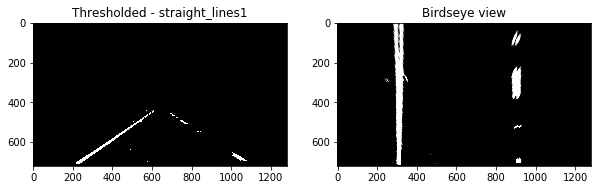

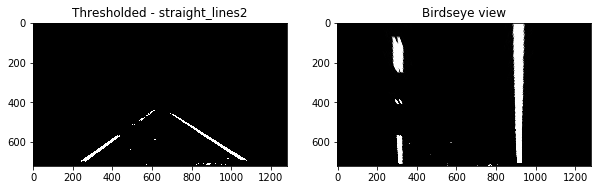

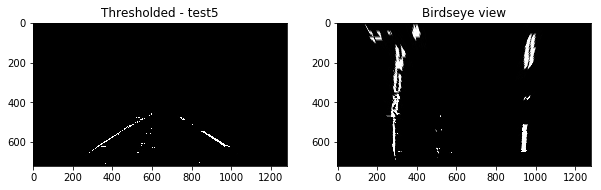

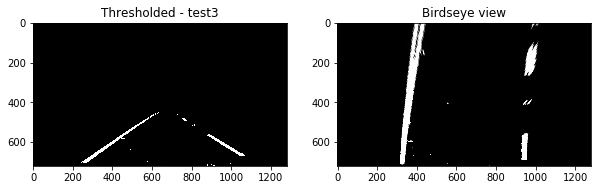

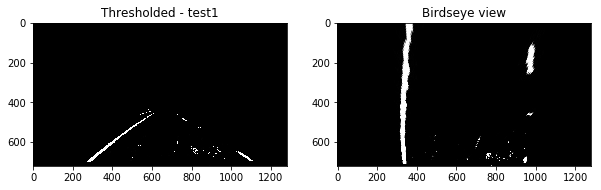

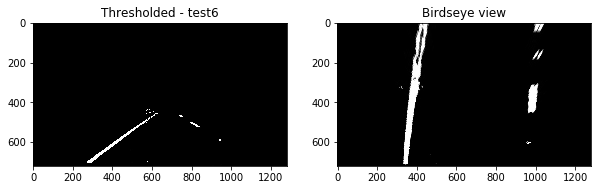

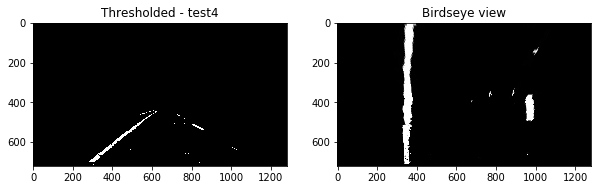

In [13]:
def warping_all(images):
    for fname in images:
        img = cv2.imread(fname)
        
        birdseye, M, Minv = warping(img)
              
        filename = fname.replace('threshold' , 'warped')
        cv2.imwrite(filename, birdseye)
        
        filename_title = fname.replace('output_images/threshold_' , '')
        filename_title = filename_title.replace('.jpg' , '')

        f, ax = plt.subplots(1, 2, figsize=(10,8))
        ax[0].imshow(img)
        title = 'Thresholded - ' + filename_title
        ax[0].set_title(title)
        ax[1].imshow(birdseye, cmap='gray')
        ax[1].set_title('Birdseye view')
    plt.show()
    
images = glob.glob('output_images/threshold_*.jpg')
warping_all(images)

<h2> Lane detection and curvature</h2>

In this section lane detection is performed. First lane detection is performed using sliding windows approach.



In [14]:
def get_histogram(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//3:,:], axis=0)
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #fig = plt.plot(histogram)
    #plt.savefig("histogram_example.png")
    
    return leftx_base, rightx_base

fname = 'output_images/warped_test3.jpg'
binary_warped = cv2.imread(fname)
leftx_base, rightx_base = get_histogram(binary_warped)

In [16]:
def find_lane_pixels(binary_warped):
    
    nwindows = 8
    margin = 50
    minpix = 100
    
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_base, rightx_base = get_histogram(binary_warped)
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    # list for left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Step through the windows one by one
    # this code was used from the lecture
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]


    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

Since consecutive frames usually have lanes in simillar positions, another approch is applied. In this approach search is done in area of margin pixels of the previously detected location.

In [17]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    
    margin = 100
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, ploty, left_fitx, right_fitx

After lanes are deteted, lane curvature is calculated.

In [18]:
def measure_curvature(left_fit, right_fit, ploty):
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def measure_real_world(img, left_fitx, right_fitx, ploty):
    ym_per_pixel = 22/720
    xm_per_pixel = 3.7/600
    
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pixel, left_fitx*xm_per_pixel, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pixel, right_fitx*xm_per_pixel, 2)
    
    # Calculate the new radii of curvature
    left_real_world = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pixel + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_real_world = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pixel + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    max_x = img.shape[1]*xm_per_pixel
    max_y = img.shape[0]*ym_per_pixel

    car_position = max_x / 2
    left_line = left_fit_cr[0]*max_y*2 + left_fit_cr[1]*max_y + left_fit_cr[2]
    right_line = right_fit_cr[0]*max_y**2 + right_fit_cr[1]*max_y + right_fit_cr[2]
    middle_line = left_line + (right_line - left_line)/2

    lane_curvature = (left_real_world + right_real_world)/2
    distance_car_midlle_line = middle_line - car_position
    
    return lane_curvature, distance_car_midlle_line

Lane curvature and car offset in m for:test2.jpg
953.900856229
0.113018664481
Lane curvature and car offset in m for:test5.jpg
1326.49348405
-0.179193987228
Lane curvature and car offset in m for:straight_lines1.jpg
1764.17505171
-0.239257582132
Lane curvature and car offset in m for:test1.jpg
721.899994343
-0.271004947048
Lane curvature and car offset in m for:test6.jpg
523.001446874
-0.203005692548
Lane curvature and car offset in m for:test4.jpg
993.468420141
0.161491317722
Lane curvature and car offset in m for:test3.jpg
794.255798472
-0.106365580767
Lane curvature and car offset in m for:straight_lines2.jpg
2216.02218653
-0.0819764180167


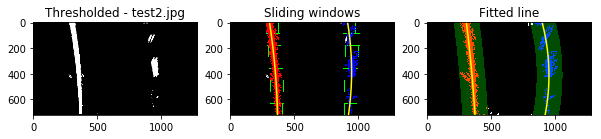

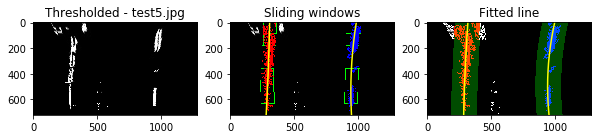

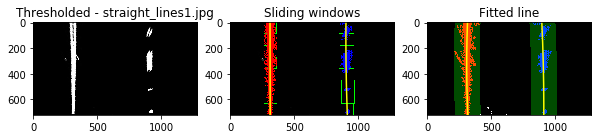

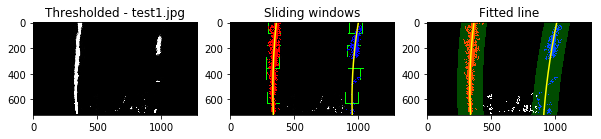

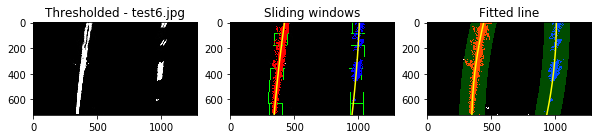

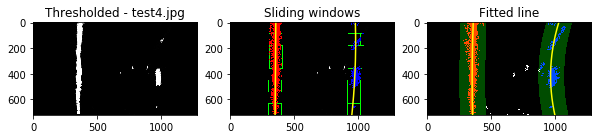

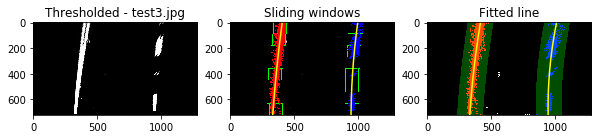

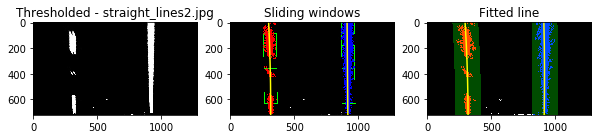

In [19]:
def polyfit_all(images):
    for fname in images:
        img = cv2.imread(fname, 0)
        
        filename = fname.replace('output_images/warped_' , 'test_images/')
        img_full = cv2.imread(filename, 0)
        img_polyfit, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(img)
     
        filename = fname.replace('warped' , 'polyfit')
        cv2.imwrite(filename, img_polyfit)
        
        left_curverad, right_curverad = measure_curvature(left_fit, right_fit, ploty)
        
        result, ploty2, left_fitx2, right_fitx2 = search_around_poly(img, left_fit, right_fit)
        filename = filename.replace('polyfit' , 'curvature')
        cv2.imwrite(filename, result)
        
        filename_title = fname.replace('output_images/warped_' , '')
        
        lane_curvature, distance_car_midlle_line = measure_real_world(img, left_fitx2, right_fitx2, ploty2)
        print('Lane curvature and car offset in m for:' + filename_title)
        print(lane_curvature)
        print(distance_car_midlle_line)
        
        f, ax = plt.subplots(1, 3, figsize=(10,8))
        ax[0].imshow(img, 'gray')
        title = 'Thresholded - ' + filename_title
        ax[0].set_title(title)
        ax[1].imshow(img_polyfit)
        ax[1].plot(right_fitx, ploty, color='yellow')
        ax[1].plot(left_fitx, ploty, color='yellow')
        ax[1].set_title('Sliding windows')
        ax[2].imshow(result)
        ax[2].plot(right_fitx2, ploty2, color='yellow')
        ax[2].plot(left_fitx2, ploty2, color='yellow')
        ax[2].set_title('Fitted line')
        
    plt.show()

images = glob.glob('output_images/warped_*.jpg')
polyfit_all(images)

Calculate lines are applied on initial testing images and result is saved in output_images/full*.jpg.

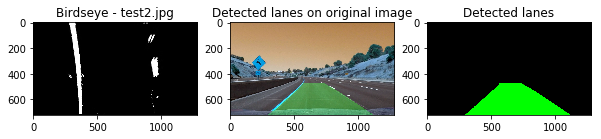

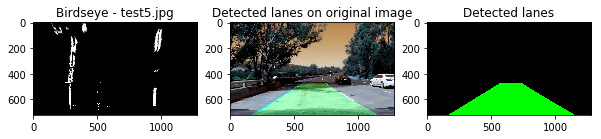

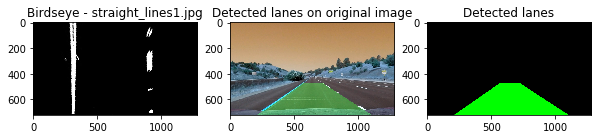

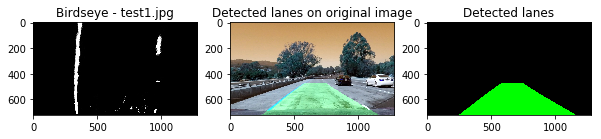

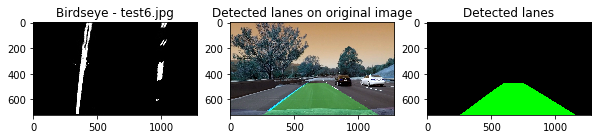

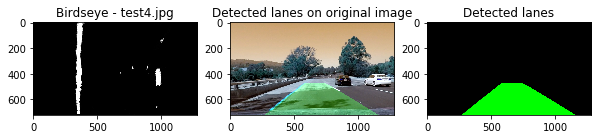

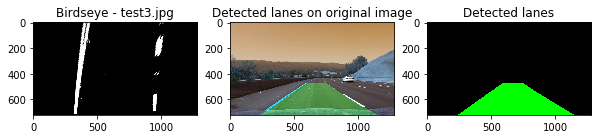

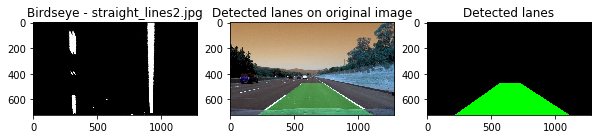

In [20]:
def show_on_full_image(images):
    for fname in images:
        img = cv2.imread(fname, 0)
        img_size = (img.shape[1], img.shape[0])
        
        filename = fname.replace('output_images/warped_' , 'test_images/')
       
        img_full = cv2.imread(filename)
        
        img_polyfit, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(img)
        left_curverad, right_curverad = measure_curvature(left_fit, right_fit, ploty)
        result, ploty2, left_fitx2, right_fitx2 = search_around_poly(img, left_fit, right_fit)
       
        lane_curvature, offset = measure_real_world(img, left_fitx2, right_fitx2, ploty2)
        #print('Curvature in m:')
        #print(lane_curvature)
        #print('Offse from car center:')
        #print(offset)
        
        birdseye, M, Minv = warping(img_full)
        
        warp_zero = np.zeros_like(img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
        # Combine the result with the original image
        
        result = cv2.addWeighted(img_full, 1, newwarp, 0.3, 0)
        
        f, ax = plt.subplots(1, 3, figsize=(10,8))
        ax[0].imshow(img, 'gray')
        filename_title = fname.replace('output_images/warped_' , '')
        title = 'Birdseye - ' + filename_title
        ax[0].set_title(title)
        ax[1].imshow(result)
        ax[1].set_title('Detected lanes on original image')
        ax[2].imshow(newwarp)
        ax[2].set_title('Detected lanes')
        
        filename_save = fname.replace('warped_' , 'full_')
        cv2.imwrite(filename_save, result)
        
    plt.show()

images = glob.glob('output_images/warped_*.jpg')
show_on_full_image(images)


<h2> Complete pipeline</h2>

In this section all parts of code are composed in complete pipeline.



In [21]:
def full_pipeline(img):
    # read calibration matrices
    with open('camera_cal/cal_pickle.p', 'rb') as calib_file:
        p = pickle.load(calib_file)
        mtx = p['mtx']
        dist = p['dist']

    # undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    sobel_threshold = thresholding_sobel(undist)
    color_threshold = thresholding_color(undist)
    threshold_img1 = cv2.bitwise_or(sobel_threshold, color_threshold)
    
    threshold_hsv = hsv_thresholding(undist)
    threshold_hls = hls_thresholding(undist)
    threshold_img2 = cv2.bitwise_or(threshold_hsv, threshold_hsv)
    threshold_img = cv2.bitwise_or(threshold_img1, threshold_img2)
    
    imshape = threshold_img.shape
    vertices = np.array([[
        (0.15 * imshape[1] ,imshape[0]), 
        (0.45 * imshape[1], 0.6 * imshape[0]), 
        (0.6 * imshape[1], 0.65 * imshape[0]),
        (0.9 * imshape[1], imshape[0]) 
    ]], dtype=np.int32)
    threshold_img = region_of_interest(threshold_img, vertices)
    
    birdseye, M, Minv = warping(threshold_img)
    img_size = (threshold_img.shape[1], threshold_img.shape[0])
         
    img_polyfit, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(birdseye)
    left_curverad, right_curverad = measure_curvature(left_fit, right_fit, ploty)
    result, ploty2, left_fitx2, right_fitx2 = search_around_poly(birdseye, left_fit, right_fit)

    lane_curvature, offset = measure_real_world(birdseye, left_fitx2, right_fitx2, ploty2)

    curvature_text = "Radius of curvature: %.2f m" % lane_curvature
    cv2.putText(result, curvature_text, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    offset_text = "Offset is: %.2f m" % offset
    cv2.putText(result, offset_text, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    warp_zero = np.zeros_like(birdseye).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image

    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    curvature_text = "Radius of curvature: %.2f m" % lane_curvature
    cv2.putText(result, curvature_text, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=3)
    
    offset_text = "Offset: %.2f m" % offset
    cv2.putText(result, offset_text, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=3)
    
    return result

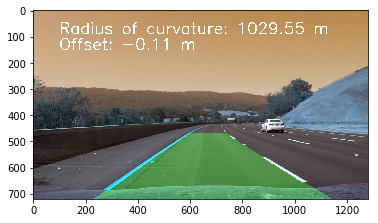

In [22]:
fname = "test_images/test3.jpg"
img = cv2.imread(fname)
result = full_pipeline(img)
#f, ax = plt.subplots(1, 2, figsize=(10,8))
#ax[0].imshow(img, 'gray')
#filename_title = fname.replace('test_images/' , '')
#title = 'Input image - ' + filename_title
#ax[0].set_title(title)
#ax[1].imshow(result)
#ax[1].set_title('Detected lanes on original image')


#curvature_text = "Radius of curvature: %.2f m" % middle_real_world
#cv2.putText(result, curvature_text, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=3)
    
#offset_text = "Offset: %.2f m" % offset
#cv2.putText(result, offset_text, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness=3)
 
plt.imshow(result)
plt.savefig('finalResultsExample.jpg')
plt.show()
#plt.savefig('finalResultsExample.jpg')


In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(full_pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [05:55<00:00,  3.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 3min 42s, sys: 3.19 s, total: 3min 45s
Wall time: 5min 58s


In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_videos/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("challenge_video.mp4")

white_clip = clip1.fl_image(full_pipeline) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|██████████| 485/485 [02:08<00:00,  3.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 1min 19s, sys: 1.34 s, total: 1min 21s
Wall time: 2min 11s


In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_videos/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("harder_challenge_video.mp4")

white_clip = clip1.fl_image(full_pipeline) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4


 50%|█████     | 606/1200 [03:20<02:46,  3.56it/s]

TypeError: expected non-empty vector for x